# World Wide Products Inc.

First, I will import the requred packages and read in the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Analysis

Now, let's look at the data we're given

In [2]:
df = pd.read_csv('./Data/Historical_Product_Demand.csv', index_col=[3], parse_dates=[3])
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500


Looking at this data, we are given 4 features to base our forecasting model on

In [3]:
rows, cols = df.shape
print(f'Our data contains {rows} rows and {cols} columns')

Our data contains 1048575 rows and 4 columns


We are given a lot of rows to work with, but not that many features. Let's take a look at how our features are distributed.

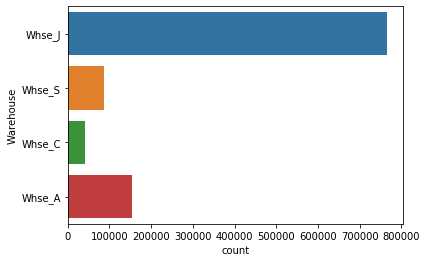

In [4]:
sns.countplot(y="Warehouse", data=df)

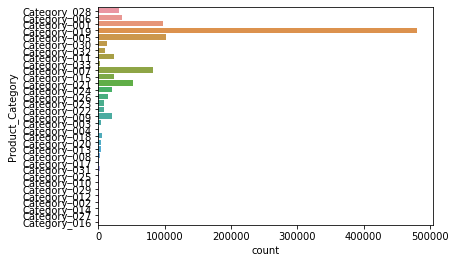

In [5]:
sns.countplot(y="Product_Category", data=df)

From this we can see that the majority of the demand comes from Category 19 and Wharehouse J. Let's see how the distribution changes when we remove that category

In [6]:
df_no_19 = df.loc[df['Product_Category'] != "Category_019"]
rows_no_19, cols_no_19 = df_no_19.shape
print(f'Our data without category 19 contains {rows_no_19} rows and {cols_no_19} columns')

Our data without category 19 contains 567476 rows and 4 columns


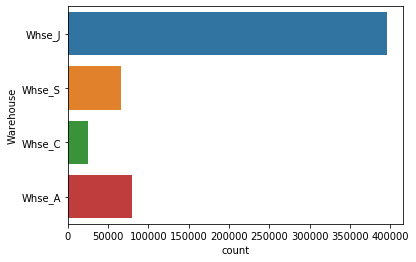

In [7]:
sns.countplot(y="Warehouse", data=df_no_19)

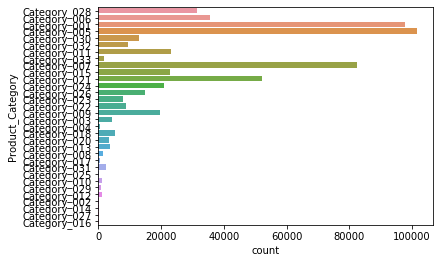

In [8]:
sns.countplot(y="Product_Category", data=df_no_19)

While our Product Categories are much more uniform, we can still see that Warehouse J takes most of the orders. Due to the increased computational complexity it takes to analyze Category 19, I will remove it from my future analysis

In [9]:
df = df_no_19

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 567476 entries, 2012-07-27 to 2016-06-27
Data columns (total 4 columns):
Product_Code        567476 non-null object
Warehouse           567476 non-null object
Product_Category    567476 non-null object
Order_Demand        567476 non-null object
dtypes: object(4)
memory usage: 41.6+ MB


Looking at the types of the columns, we will first convert Order_Demand to handle the negative case because currently the data uses parenthesis to denote a loss and convert to integer.

In [11]:
df['Order_Demand'] = df['Order_Demand'].astype(str)
df['Order_Demand'] = df['Order_Demand'].replace('[(]', '-', regex=True).astype(str)
df['Order_Demand'] = df['Order_Demand'].replace('[)]', '', regex=True).astype(int)

df['Product_Category'] = df['Product_Category'].astype(str)
df['Product_Category'] = df['Product_Category'].replace('[Category_]', '', regex=True).astype(int)

df['Product_Code'] = df['Product_Code'].astype(str)
df['Product_Code'] = df['Product_Code'].replace('[Product_]', '', regex=True).astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 567476 entries, 2012-07-27 to 2016-06-27
Data columns (total 4 columns):
Product_Code        567476 non-null int64
Warehouse           567476 non-null object
Product_Category    567476 non-null int64
Order_Demand        567476 non-null int64
dtypes: int64(3), object(1)
memory usage: 41.6+ MB


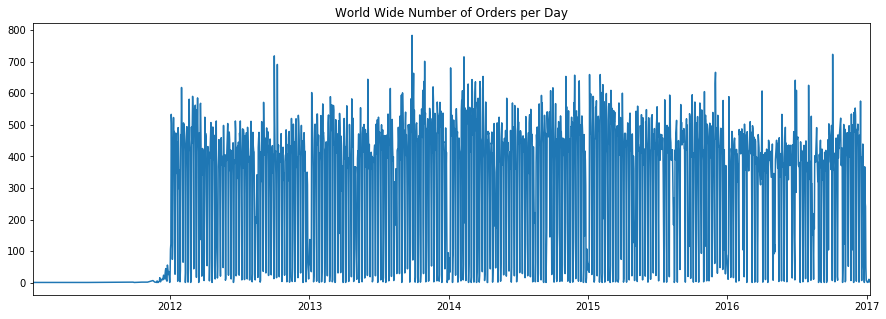

In [13]:
df.groupby([df.index.date]).count().Order_Demand.plot(figsize=(15,5), title='World Wide Number of Orders per Day')

We can see here that the number of orders on days that there are orders is pretty consistent at around 600. However, there are frequent days with little to no orders which may correspond to weekends.

In [14]:
df.sort_values(['Date', 'Product_Code', 'Order_Demand'], inplace=True)
df.head(20)

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-01-08,965,Whse_A,6,2
2011-05-31,1724,Whse_A,3,108
2011-09-27,608,Whse_C,1,5
2011-09-27,1933,Whse_C,1,23
2011-09-30,875,Whse_C,23,5450
2011-10-20,125,Whse_S,11,-2
2011-10-20,412,Whse_S,7,-2
2011-11-04,202,Whse_A,7,-400
2011-11-04,202,Whse_A,7,-100


We can see here that some products have multiple orders per day. I will group these into a total per day. I am also going to scope my project to analyze on the per-product level and not take into account the warehouse so I will drop that column.

In [15]:
df = df.groupby(['Date','Product_Code', 'Product_Category']).sum().reset_index().set_index('Date')
df.sort_values(['Date', 'Product_Code'], inplace=True)
df.head(15)

,Product_Code,Product_Category,Order_Demand
Date,,,
2011-01-08,965,6,2
2011-05-31,1724,3,108
2011-09-27,608,1,5
2011-09-27,1933,1,23
2011-09-30,875,23,5450
2011-10-20,125,11,-2
2011-10-20,412,7,-2
2011-11-04,202,7,-500
2011-11-18,131,21,-12


Now, I am going to analyze how the demand per category changes throughout time.

In [16]:
df_categories = df.groupby([ 'Date','Product_Category']).sum().reset_index().set_index('Date')
df_categories.head()

,Product_Category,Product_Code,Order_Demand
Date,,,
2011-01-08,6,965,2
2011-05-31,3,1724,108
2011-09-27,1,2541,28
2011-09-30,23,875,5450
2011-10-20,7,412,-2


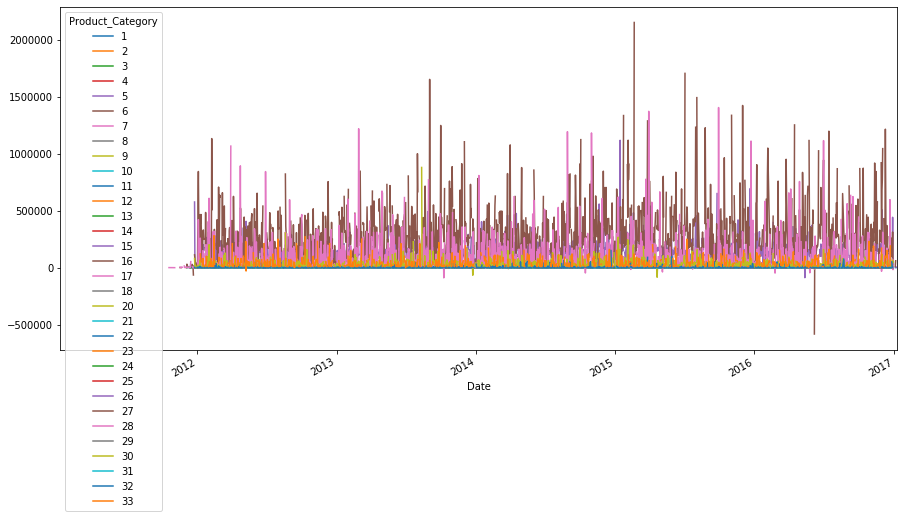

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby([ 'Date','Product_Category']).sum()['Order_Demand'].unstack().plot(ax=ax)

From the graph above, we have obvious fluxuations in order demand both within and between categories. I'm now going to add a day of the week feature.

In [18]:
df['Weekday'] = df.index.map(lambda d : d.weekday())
df.head()

,Product_Code,Product_Category,Order_Demand,Weekday
Date,,,,
2011-01-08,965,6,2,5
2011-05-31,1724,3,108,1
2011-09-27,608,1,5,1
2011-09-27,1933,1,23,1
2011-09-30,875,23,5450,4


Because of the increased complexity with a multi variate time series, I am going to restrict myself to one product code with the hopes of expanding my model futher in the future to account for more products simultaneously. I picked product 349 because of it's high number of order days.

In [19]:
series = df.loc[df['Product_Code'] == 349]['Order_Demand']
series = series.resample('D').sum()
series.tail(5)

Date
2016-12-22     96
2016-12-23     21
2016-12-24      0
2016-12-25      0
2016-12-26    600
Freq: D, Name: Order_Demand, dtype: int64

Because our dates end near the end of 2016, I'm going to use 2016 as my test data with everything beforehand as my train data.

In [20]:
train_series = series.loc[series.index < "2016-01-01"]
test_series = series.loc[series.index >= "2016-01-01"]

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                 1467
Model:                     ARMA(2, 2)   Log Likelihood               -9727.999
Method:                       css-mle   S.D. of innovations            182.990
Date:                Sun, 01 Dec 2019   AIC                          19467.998
Time:                        19:03:08   BIC                          19499.744
Sample:                    12-26-2011   HQIC                         19479.838
                         - 12-31-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8544      4.785     -0.179      0.858     -10.233       8.524
ar.L1.Order_Demand     1.2472      0.000   4990.220      0.000       1.247       1.248
ar.L2.Order_Demand  

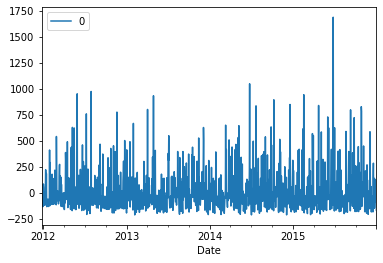

In [21]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
train2 = (train_series - train_series.mean())
model = ARIMA(train2, order=(2, 0, 2), freq='D')
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

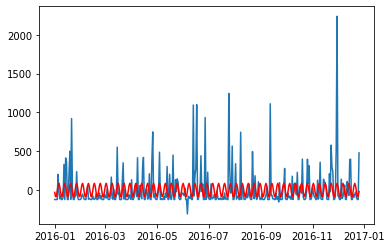

In [22]:
test2 = (test_series - train_series.mean())
from sklearn.metrics import r2_score
start_predict_date = test2.index[0]
end_predict_date = test2.index[-1]
predictions = model_fit.predict(start=start_predict_date, end=end_predict_date)

plt.plot(test2)
plt.plot(predictions, color='red')
plt.show()

In [23]:
r2_score(test2, predictions)

0.044228275670216366

This is something. Definitely a lot better than my first attempt at using this model, however, I found an auto arima model that checks many parameters to find the optimal fit of an arima model with seasonality so i'm going to see if I can achieve better results using that.

In [24]:
# Install a pip package in the current Jupyter kernel if you dont already have it
# import sys
# !{sys.executable} -m pip install pmdarima

In [25]:
import pmdarima as pm

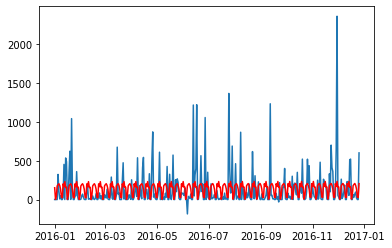

In [26]:
rs_fit = pm.auto_arima(train_series, start_p=0, start_q=0, max_p=10, max_d=10, max_q=10, m=7,
                       start_P=0, max_P=10, max_D=10, max_Q=10, seasonal=True,
                       stationary=False,
                       d=1, D=1,
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=True, )

predictions = rs_fit.fit_predict(train_series,n_periods=test_series.shape[0])
predictions_df = pd.DataFrame(predictions)
predictions_df.index = test_series.index
plt.plot(test_series)
plt.plot(predictions_df, color='red')
plt.show()

This seems about the same as the previous model.

In [27]:
r2_score(test_series, predictions)

0.09687051752862064

But we can see the r^2 score is more than double. I'm now going to see if we can get better results by forecasting monthly data.

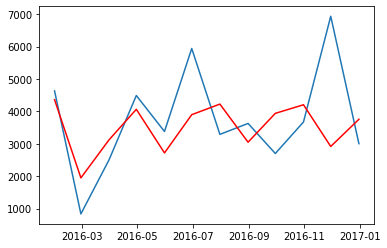

In [28]:
series_monthly = df.loc[df['Product_Code'] == 349]['Order_Demand']
series_monthly = series_monthly.resample('M').sum()
train_series_monthly = series_monthly.loc[series_monthly.index < "2016-01-01"]
test_series_monthly = series_monthly.loc[series_monthly.index >= "2016-01-01"]
rs_fit_monthly = pm.auto_arima(train_series_monthly, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
predictions_monthly = rs_fit_monthly.fit_predict(train_series_monthly,n_periods=test_series_monthly.shape[0])
predictions_monthly_df = pd.DataFrame(predictions_monthly)
predictions_monthly_df.index = test_series_monthly.index
plt.plot(test_series_monthly)
plt.plot(predictions_monthly_df, color='red')
plt.show()

In [29]:
r2_score(test_series_monthly, predictions_monthly)

0.07489096862472866

### Conclusion

I thought reducing the data frequency to monthly would increase accuracy, but it seems that makes the data even more sparadic and harder to predict. Overall, I'm happy with the knowlege I gained about forecasting, Arima model, and auto ML libraries for selecting the parameters that go in models. 